<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Relacion_Desplazamiento_Velocidad_Aceleracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relación entre posición, velocidad y desplazamiento

La primera vez, ejecuta la primera celda (botón "Play" en la parte superior izquierda de la celda).

A partir de ahí, cada vez que ejecutes la segunda celda, se creará una curva de posición aleatoria con sus curvas de velocidad y aceleración.

Las líneas verticales verdes indican cuándo la velocidad corta por el cero.

Las líneas verticales azules indican cuándo la aceleración corta por el cero.

In [1]:

#Crea una gráfica de posición aleatoria y después la de velocidad y aceleración asociadas.

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages #para guardar gráficas en pdf
import numpy as np
from scipy import interpolate 
import sys
import os
import time
#sys.path.insert(1, r'J:\Programacion\Python\Mios\Functions')  # add to pythonpath
#from tnorm import tnorm #para normalizar series de datos
#from detect_onset import detect_onset
!pip install detecta
from detecta import detect_onset


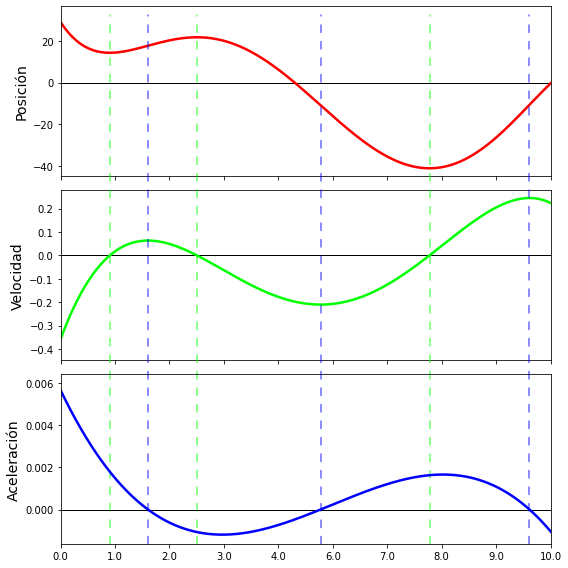

In [8]:
#@title Relación entre posición, velocidad y aceleración

# =============================================================================
# Define condicionales
# =============================================================================
bGraficasPruebas = False
bGraficaCompleta = True #Crea la figura con todas las gráficas limpias
bDatosInicialesAMano = False #si es false, los saca aleatorios
bCalculoInterpolando = False #interpolando requiere de separaciones iguales en eje X.; Si es falso, calcula la curva de ajuste con el grado que se indique.
# =============================================================================

numGraficas = 1
numDatos = 1000
nExtrapolacion = 10 #datos en X antes y después de la ventana visible
rangoY = 100 #Rango variable en el eje Y
gradoPolin = 5
rangoDatosInicial = [7,12]
colorVar = [[1,0,0], [0,1,0], [0,0,1]] #por orden D, V, A

#Función para calcular derivada por método diferencias finitas central
def derivar(DatOrig, x):
    d_DatOrig = np.zeros(len(DatOrig), np.float)
    d_DatOrig[1:-1] = (DatOrig[2:] - DatOrig[:-2]) / (x[2:] - x[:-2])
    
    # calcula el primero y el último
    d_DatOrig[0] = (DatOrig[1] - DatOrig[0]) / (x[1] - x[0])
    d_DatOrig[-1] = (DatOrig[-1] - DatOrig[-2]) / (x[-1] - x[-2])
    return d_DatOrig


# =============================================================================
# Empieza a procesar todas las gráficas
# =============================================================================
for nGraf in range(numGraficas):
    if bDatosInicialesAMano:
        #Entrada de datos X e Y a mano
        data = np.array([
               [-nExtrapolacion,  85.91247806],
               [185, 150],
               [207,  189.73686096],
               [304, 124.91312292],
               [367,  42.68889048],
               [468,  74.26467954],
               [numDatos+nExtrapolacion,  74.26467954],
               ])
        x = data[:,0]
        y = data[:,1]
    
    
    #Datos aleatorios de puntos clave
    else:
        #np.random.seed(1234)
        n = np.random.randint(rangoDatosInicial[0], rangoDatosInicial[1])
        #x = np.arange(0,100, 10)
        x = np.linspace(-nExtrapolacion,numDatos+nExtrapolacion,n)
        y = np.random.rand(len(x))*rangoY-rangoY/2
    
    
    #Variable tiempo
    t = np.linspace(min(x), max(x), numDatos+2*nExtrapolacion)
    
    #################################
    #Calcula Desplazamiento
    
    if bCalculoInterpolando:
        D, tn, indie = tnorm(y, k=4, step=-(numDatos+2*nExtrapolacion), smooth=0, show=bGraficasPruebas)
        #interp = interpolate.interp1d(x, y, kind='cubic') #otras opciones de interpolar son: 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'
        D = interp(t)
        
        
        # spline = interpolate.splrep(x, y)
        # D = interpolate.splev(t, spline, der=0)
        
    else:    
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression
        
        polynomial_features = PolynomialFeatures(degree=gradoPolin, include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
        pipeline.fit(x[:, np.newaxis], y)    
        
        D = pipeline.predict(t[:, np.newaxis])
        D_predict = pipeline.predict(x[:, np.newaxis]) #Calcula puntos de la predicción en las posiciones de X
    
    if bGraficasPruebas:
        plt.plot(t,D)
        #plt.plot(x,D_predict, 'ro')
        plt.plot(x, y, 'bo')
        plt.show()
    
    #################################
    
    #Calcula velocidad
    V = derivar(D, t)
        
    #Calcula aceleración
    A = derivar(V, t)
        
    
    ######################################
    #Busca cortes por el cero en velocidad
    indV = detect_onset(V, 0.0, n_above=2, n_below=0, show=False) #empieza a buscar desde que iniciamos la medida del peso
    indV=indV.flatten()-nExtrapolacion #ajusta restando el margen que se pone para que empieze ya con vovimiento
    
    #Busca cortes por el cero en aceleración
    indA = detect_onset(A, 0.0, n_above=2, n_below=0, show=False) #empieza a buscar desde que iniciamos la medida del peso
    indA=indA.flatten()-nExtrapolacion #ajusta restando el margen que se pone para que empieze ya con vovimiento
    
    # =============================================================================
    # %%Figuras de pruebas 
    # =============================================================================
    if bGraficasPruebas:
        fig, ax = plt.subplots(figsize=(6, 4))
        plt.plot(x, y, 'bo')
        plt.plot(t, D, c=colorVar[0], lw=2, label='D')
        ax2 = ax.twinx() #crea el segundo eje
        ax2.plot(t, V, c=colorVar[1], lw=2, label='V')
        ax2.plot(t, A*10, c=colorVar[2], lw=2, label='A')
        
        plt.xlabel("tiempo", fontsize=15)
        
        plt.xlim((-nExtrapolacion, numDatos+nExtrapolacion))
        plt.legend(loc='best')
        plt.show()
    
    
    
    # =============================================================================
    # %%figura limpia 
    # =============================================================================
    if bGraficaCompleta:
        #Figura con las tres gráficas juntas
        fig, ax = plt.subplots(3,1,figsize=(8, 8), sharex=True)#, dpi=200)
        #ax[0].plot(x, y, 'ro', lw=2)
        ax[0].plot(t, D, c=colorVar[0], lw=2.5)
        ax[0].axhline(y=0.0, color='k', lw=1, zorder=1)
        ax[0].set_ylabel('Posición', fontsize=14)
        
        ax[1].plot(t, V, c=colorVar[1], lw=2.5)
        ax[1].axhline(y=0.0, color='k', lw=1, zorder=1)
        ax[1].set_ylabel('Velocidad', fontsize=14)
        
        ax[2].plot(t, A, c=colorVar[2], lw=2.5)
        ax[2].axhline(y=0.0, color='k', lw=1, zorder=1)
        ax[2].set_ylabel('Aceleración', fontsize=14)
        
        #Dibuja líneas división según cortes por cero de la velocidad
        for i in indV[(indV>0) & (indV<numDatos-nExtrapolacion)]: #dibuja solo los que están dentro de la gráfica
            ax[2].axvline(x=i, ymin=0, ymax=3.115, c=colorVar[1], ls='--', linewidth=1.5, alpha=0.6, dash_capstyle='round', dashes=(5, 6), zorder=0, clip_on=False)
        
        for i in indA[(indA>0) & (indA<numDatos-nExtrapolacion)]:
            ax[2].axvline(x=i, ymin=0, ymax=3.115, c=colorVar[2], ls='--', linewidth=1.5, alpha=0.6, dash_capstyle='round', dashes=(5, 6), zorder=0, clip_on=False)
        
        plt.xlim((0, numDatos))
        
        #sustituye las etiquetas del eje X para que se ajusten de 0 a 10 
        plt.xticks(np.linspace(0, 1000, 10), np.round(np.linspace(0, 10, 10),0))
        
        plt.tight_layout()
        plt.show()
        
